In [5]:
import janitor
import pandas as pd
import matplotlib.pyplot as plt; plt.style.use('seaborn')

In [6]:
# Import hires data

hires = (
    pd.read_csv('data/cycle_hires/179JourneyDataExtract11Sep2019-17Sep2019.csv')
    .clean_names()
    .dropna()
    .drop_duplicates()
    .to_datetime('end_date', format='%d/%m/%Y %H:%M')
    .to_datetime('start_date', format='%d/%m/%Y %H:%M')
)

print(hires.shape)
hires.head()

(249189, 9)


,rental_id,duration,bike_id,end_date,endstation_id,endstation_name,start_date,startstation_id,startstation_name
0,91113807,240,16022,2019-09-11 13:25:00,125,"Borough High Street, The Borough",2019-09-11 13:21:00,10,"Park Street, Bankside"
1,91265425,2400,15227,2019-09-15 15:39:00,532,"Jubilee Plaza, Canary Wharf",2019-09-15 14:59:00,237,"Dock Street, Wapping"
2,91210424,480,9654,2019-09-13 22:04:00,715,"Aylward Street, Stepney",2019-09-13 21:56:00,444,"Bethnal Green Garden, Bethnal Green"
3,91190653,540,3586,2019-09-13 13:55:00,715,"Aylward Street, Stepney",2019-09-13 13:46:00,444,"Bethnal Green Garden, Bethnal Green"
4,91274678,360,16132,2019-09-15 17:56:00,648,"Peterborough Road, Sands End",2019-09-15 17:50:00,671,"Parsons Green Station, Parsons Green"


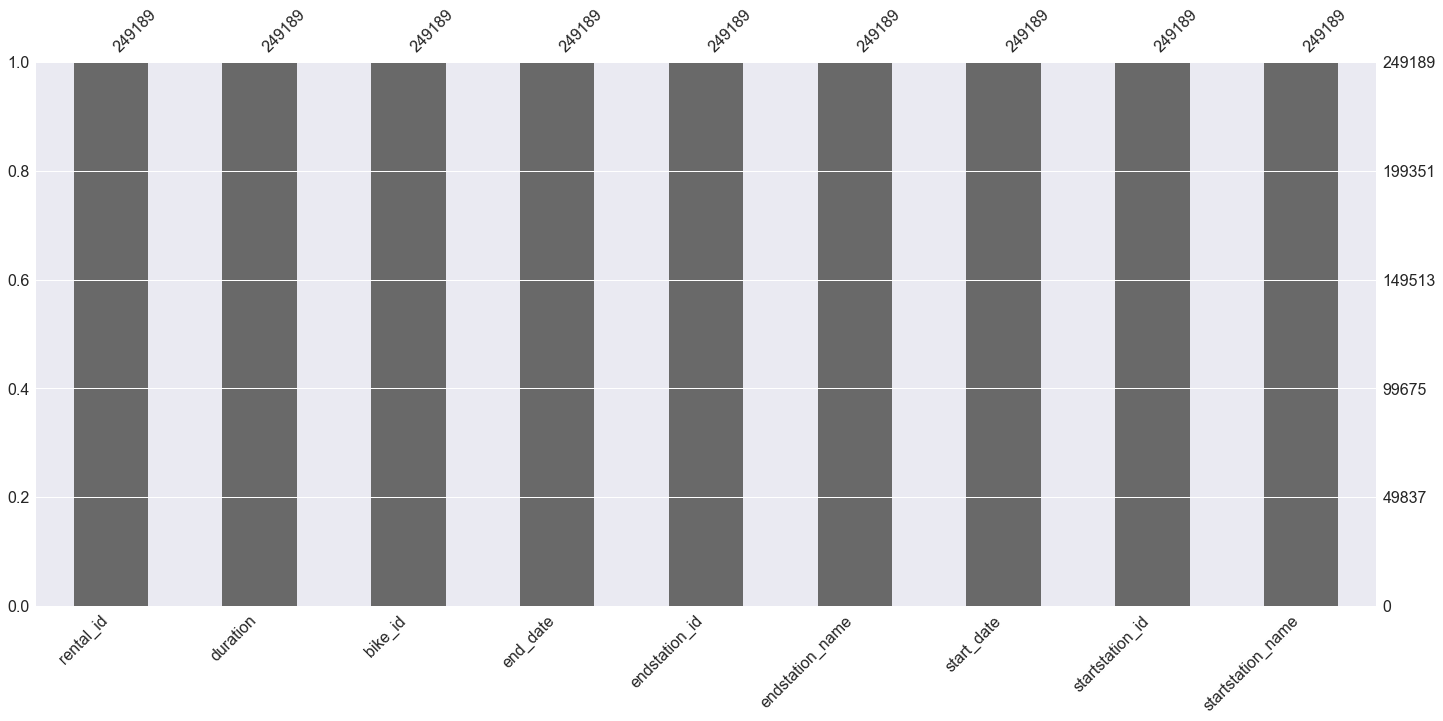

In [7]:
# Visualise missings

import missingno as msno
msno.bar(hires);

In [31]:
# Load station locations data

import geopandas as gpd
import requests
from xml.etree import ElementTree as ET


url = "https://tfl.gov.uk/tfl/syndication/feeds/cycle-hire/livecyclehireupdates.xml"

response = requests.get(url)
root = ET.fromstring(response.content)

ids = [int(root[i][0].text) for i in range(0, len(root))]
names = [root[i][1].text for i in range(0, len(root))]
lats = [float(root[i][3].text) for i in range(0, len(root))]
lons = [float(root[i][4].text) for i in range(0, len(root))]
capacities = [int(root[i][12].text) for i in range(0, len(root))]

df = pd.DataFrame(list(zip(ids, names, lats, lons, capacities)),
                        columns=['id', 'name', 'longitude', 'latitude', 'capacity'])

stations = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.latitude, df.longitude))
stations.crs = {'init' :'epsg:4326'}

print(stations.shape)
stations.head()


(785, 6)


,id,name,longitude,latitude,capacity,geometry
0,1,"River Street , Clerkenwell",51.529163,-0.109971,19,POINT (-0.10997 51.52916)
1,2,"Phillimore Gardens, Kensington",51.499607,-0.197574,37,POINT (-0.19757 51.49961)
2,3,"Christopher Street, Liverpool Street",51.521284,-0.084606,32,POINT (-0.08461 51.52128)
3,4,"St. Chad's Street, King's Cross",51.530059,-0.120974,23,POINT (-0.12097 51.53006)
4,5,"Sedding Street, Sloane Square",51.493130,-0.156876,27,POINT (-0.15688 51.49313)


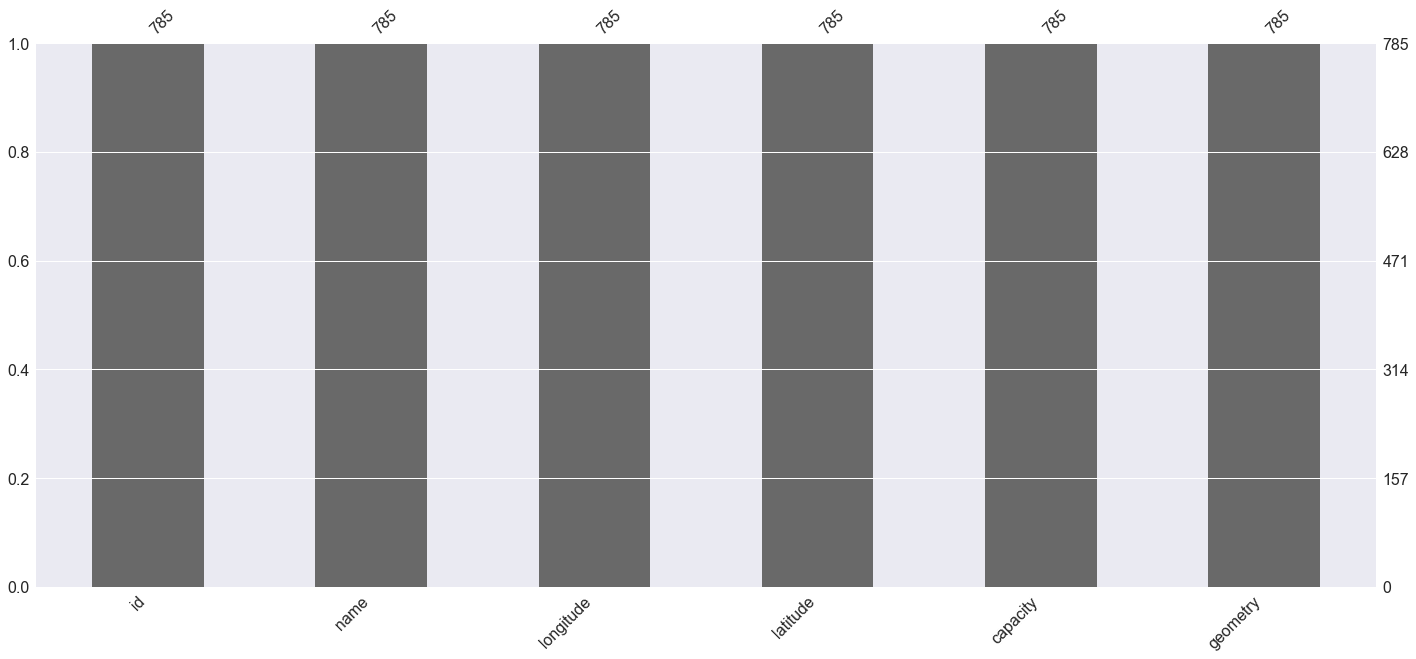

In [10]:
# Check for missings

msno.bar(stations);

In [ ]:
# UK maps from https://www.ordnancesurvey.co.uk/opendatadownload/products.html#OPROAD
# buildings = gpd.read_file('data/geo_data/OS OpenMap Local (ESRI Shape File) TQ/TQ_Building.shp')

In [ ]:
# Load borough boundaries 

boundaries = get_borough_boundaries().set_index('name')

# Ensure that crs matches
stations = stations.to_crs(boundaries.crs)



(522002.0010688451, 539233.218112194, 173908.00066947204, 185752.0598131594)

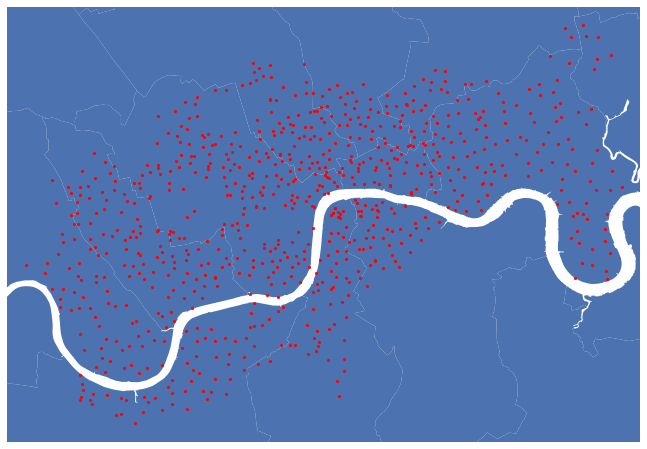

In [69]:
# Plot station locations

from toolbox.toolbox import get_borough_boundaries

fig, ax = plt.subplots(1, 1, figsize=(16,8))

xmin = stations['geometry'].bounds.minx.min() - 500
xmax = stations['geometry'].bounds.maxx.max() + 500
ymin = stations['geometry'].bounds.miny.min() - 500
ymax = stations['geometry'].bounds.maxy.max() + 500

base = boundaries.plot(ax=ax)
stations.plot(ax=base, marker='o', color='red', markersize=8)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.axis('off')

In [56]:
stations.geometry.bounds.minx.max()

538733.2181100511

# Old graph

In [1]:
# Load data and combine borough boundaries and profiles

from toolbox.toolbox import get_stations_data
from toolbox.toolbox import get_borough_boundaries
from toolbox.toolbox import get_borough_profiles

stations = get_stations_data()
boundaries = get_borough_boundaries().set_index('name')
profiles = get_borough_profiles().set_index('area_name')

boroughs = boundaries.join(profiles)
boroughs.head()

,geometry,population,average_age,prop_working_age,happiness,anxiety,childhood_obesity_preval,labour_seats
name,,,,,,,,
Kingston upon Thames,"POLYGON ((516401.600 160201.800, 516407.300 16...",175400,37.1,67.2,7.4,3.3,16.9,4.2
Croydon,"POLYGON ((535009.200 159504.700, 535005.500 15...",386500,37.0,64.9,7.2,3.3,24.5,57.1
Bromley,"POLYGON ((540373.600 157530.400, 540361.200 15...",327900,40.2,62.6,7.4,3.3,16,11.7
Hounslow,"POLYGON ((521975.800 178100.000, 521967.700 17...",274200,35.8,67.6,7.4,3.4,24.1,81.7
Ealing,"POLYGON ((510253.500 182881.600, 510249.900 18...",351600,36.2,66.8,7.3,3.6,23.8,76.8


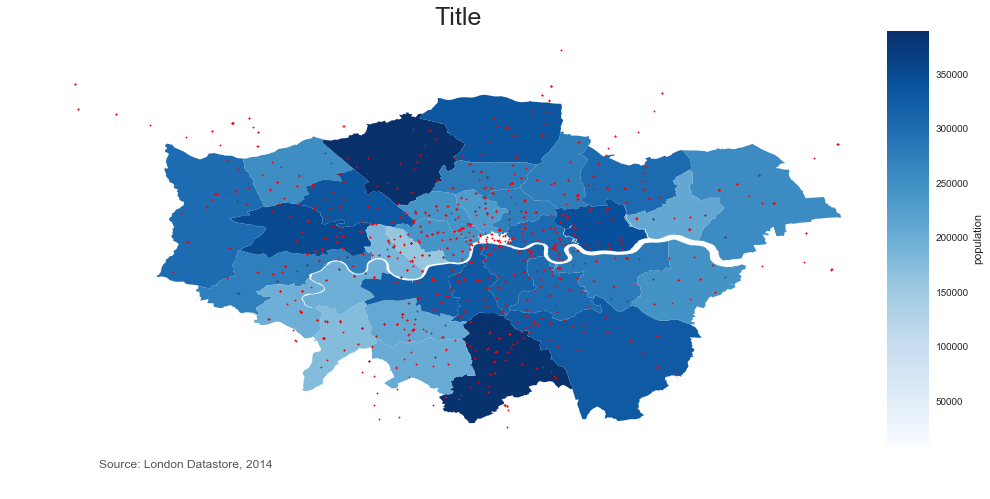

In [6]:
import geopandas
from mpl_toolkits.axes_grid1 import make_axes_locatable

variable = 'population'

# Ensure that maps have the same crs
boroughs = boroughs.to_crs(stations.crs)

# Create borough map as base
fig, ax = plt.subplots(1, 1, figsize=(16,8))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
base = boroughs.plot(column=variable, cmap='Blues', ax=ax, cax=cax,
                     legend=True, legend_kwds={'label':variable})

# Plot stations on top of base
stations.plot(ax=base, marker='o', color='red', markersize=2)

ax.axis('off')
ax.set_title('Title', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.annotate('Source: London Datastore, 2014',xy=(0.1, .08),  
            fontsize=12, color='#555555',
            xycoords='figure fraction', 
            horizontalalignment='left', verticalalignment='top', );

# Misc.

In [ ]:
# Load cycle hire data from website

url = 'https://cycling.data.tfl.gov.uk/usage-stats/'
csv_list = ['179JourneyDataExtract11Sep2019-17Sep2019.csv']

url_list = [url + f for f in csv_list]
df_list = (pd.read_csv(f) for f in url_list)

df = (
    pd.concat(df_list)
    ...